# Summary

In this notebook I extracted the subset of the MagNet data that was used to generate table IV in the Chen paper https://drive.google.com/file/d/1-gQivmT4mBBujh6kf6oiac2_grpg0Pkx/view?usp=sharing:


**To use it, just copy over the last cell of this notebook**

In [ ]:
%run Lib.ipynb import load_material_data

In [ ]:
dfs = load_material_data("N87")

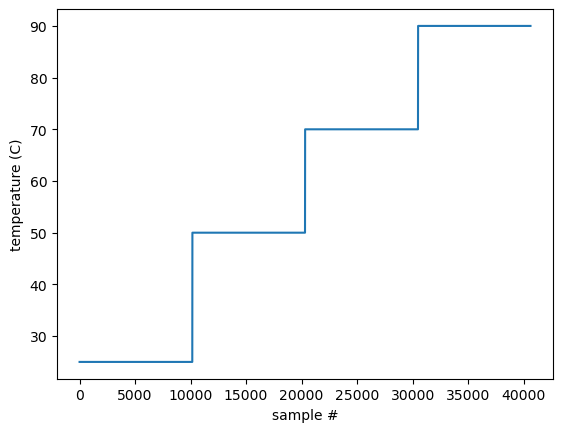

first sample above 30C: 10153


In [ ]:
import matplotlib.pyplot as plt

# figure out the structure of the dataset
plt.plot(dfs["Temp"])
plt.ylabel("temperature (C)")
plt.xlabel("sample #")
plt.show()

# find the first sample where the temperature is above 30C
first_sample = (dfs["Temp"] > 30).idxmax()[0]
print(f"first sample above 30C: {first_sample}")


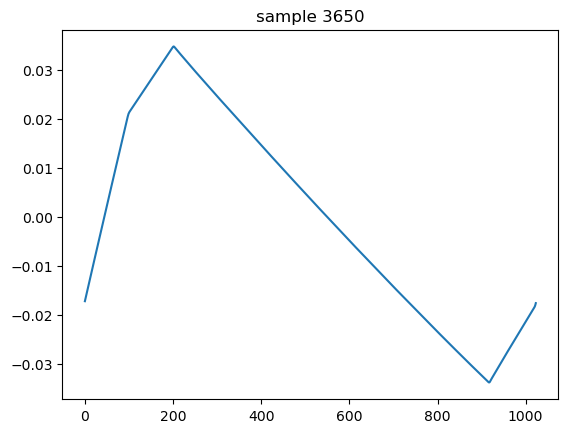

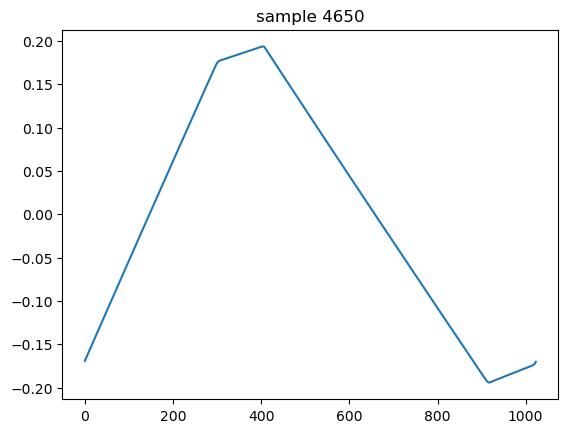

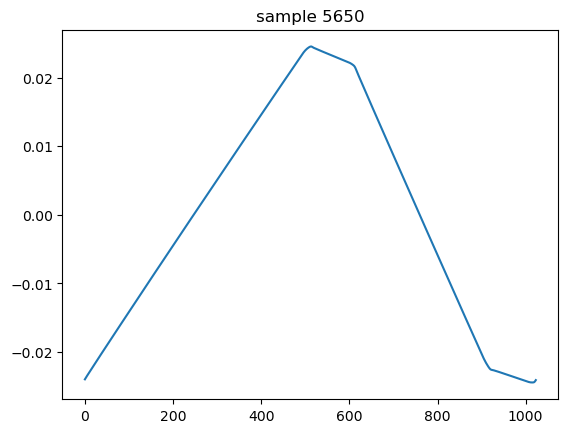

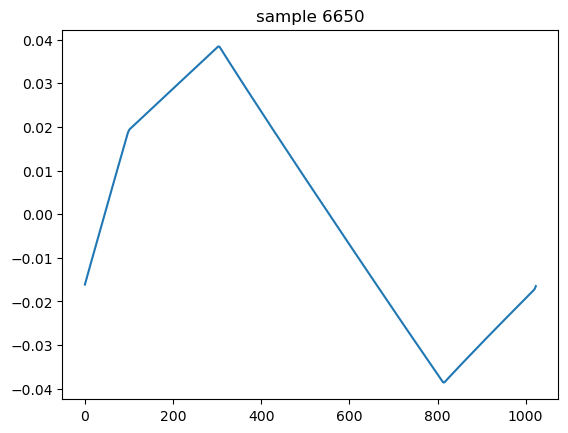

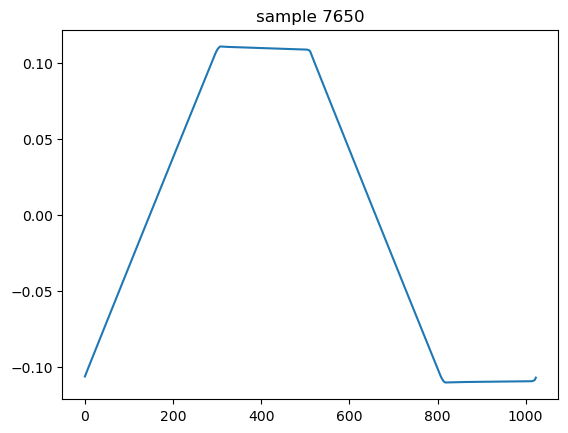

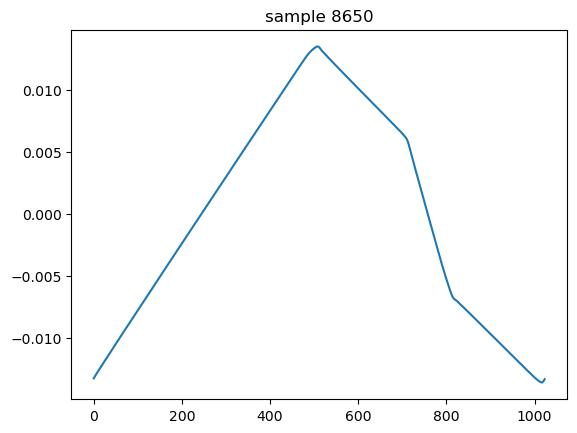

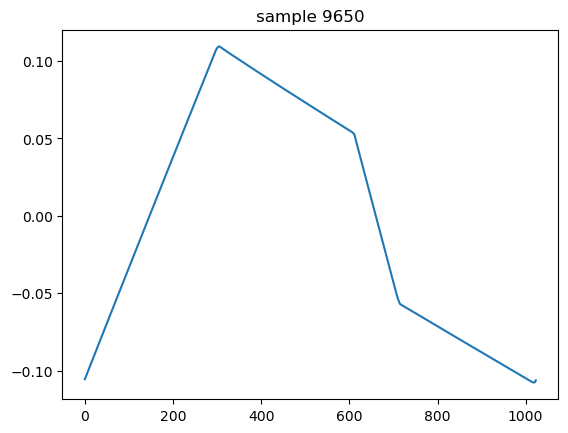

In [ ]:

# 338 is the first triangular sample in the 25C subset
# 3649 is the last triangular sample in the 25C subset


for i in range(3650, 10152, 1000):
    plt.figure()
    plt.plot(dfs["B"].T[int(i)], label=f"sample {i}")
    plt.title(f"sample {i}")
plt.show()

In [ ]:
sine_dfs = load_material_data("N87", first_row=0, last_row=337)
triangle_dfs = load_material_data("N87", first_row=338, last_row=3649)
trap_dfs = load_material_data("N87", first_row=3650, last_row=10151)

In [ ]:
# check if running on colab
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = '/content/drive/Shareddrives/EEE405 Group Project/MagnetChallenge/data'
else:
    data_dir = 'G:\Shared drives\EEE405 Group Project\MagnetChallenge\data'

import os
import pandas as pd
import numpy as np

def load_material_data(material, data_dir=data_dir, first_row=0, last_row=None):
    """
    Load the material data from the data directory.
    :return: dict of pandas dataframes
    """
    material_dir = os.path.join(data_dir, material + "_cycle")
    if last_row is not None:
        nrows = last_row - first_row + 1
    else:
        nrows = None

    return {
        "Freq": pd.read_csv(os.path.join(material_dir, "Frequency[Hz].csv"), nrows=nrows, header=None, skiprows=first_row),
        "Temp": pd.read_csv(os.path.join(material_dir, "Temperature[C].csv"), nrows=nrows, header=None, skiprows=first_row),
        "B": pd.read_csv(os.path.join(material_dir, "B_waveform[T].csv"), header=None, nrows=nrows, skiprows=first_row),
        "H": pd.read_csv(os.path.join(material_dir, "H_waveform[Am-1].csv"), header=None, nrows=nrows, skiprows=first_row),
        "Loss": pd.read_csv(os.path.join(material_dir, "Volumetric_losses[Wm-3].csv"), header=None, nrows=nrows, names=["Loss"], skiprows=first_row),
    }

sine_dfs = load_material_data("N87", first_row=0, last_row=337)
triangle_dfs = load_material_data("N87", first_row=338, last_row=3649)
trap_dfs = load_material_data("N87", first_row=3650, last_row=10151)

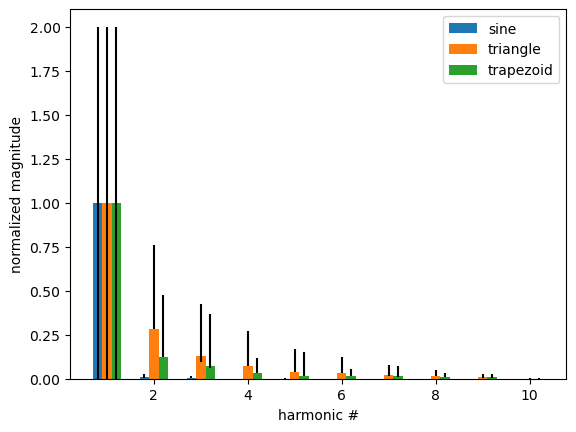

In [ ]:
# I want an automated way of classifying the waveforms. Are they separable by a simple feature like FFT magnitude?


def get_first_ten_harmonics_normalized(waveform):
    fft = np.fft.fft(waveform)
    return np.abs(fft[1:11]) / np.abs(fft[1])

sine_harmonics = np.array([get_first_ten_harmonics_normalized(waveform) for waveform in sine_dfs["B"].to_numpy()])
triangle_harmonics = np.array([get_first_ten_harmonics_normalized(waveform) for waveform in triangle_dfs["B"].to_numpy()])
trap_harmonics = np.array([get_first_ten_harmonics_normalized(waveform) for waveform in trap_dfs["B"].to_numpy()])

# plot the first 10 harmonics for each waveform as a multiple bar plot
plt.figure()
plt.bar(np.arange(1, 11) - 0.2, np.mean(sine_harmonics, axis=0), width=0.2, label="sine")
plt.bar(np.arange(1, 11), np.mean(triangle_harmonics, axis=0), width=0.2, label="triangle")
plt.bar(np.arange(1, 11) + 0.2, np.mean(trap_harmonics, axis=0), width=0.2, label="trapezoid")

plt.errorbar(np.arange(1, 11) - 0.2, np.mean(sine_harmonics, axis=0), yerr=np.array([np.min(sine_harmonics, axis=0), np.max(sine_harmonics, axis=0)]), fmt='none', ecolor='k')
plt.errorbar(np.arange(1, 11), np.mean(triangle_harmonics, axis=0), yerr=np.array([np.min(triangle_harmonics, axis=0), np.max(triangle_harmonics, axis=0)]), fmt='none', ecolor='k')
plt.errorbar(np.arange(1, 11) + 0.2, np.mean(trap_harmonics, axis=0), yerr=np.array([np.min(trap_harmonics, axis=0), np.max(trap_harmonics, axis=0)]), fmt='none', ecolor='k')
plt.legend()
plt.xlabel("harmonic #")
plt.ylabel("normalized magnitude")
plt.show()


# given a waveform of length 1024, return whether or not it's sinusoidal
def is_sinusoidal(waveform):
    # take the FFT of the waveform
    fft = np.fft.fft(waveform)
    # if the first 10 harmonics are less than 1% of the fundamental, it's sinusoidal
    result = np.all(np.abs(fft[2:10]) < 0.02 * np.abs(fft[1]))
    return result



In [ ]:
# shape sine_dfs, triangle_dfs, trap_dfs into a tensor for training.
# use one-hot encoding for the labels
# 0 = sine, 1 = triangle, 2 = trapezoid

# first normalize the waveforms
sine_waveforms = sine_dfs["B"].to_numpy()
triangle_waveforms = triangle_dfs["B"].to_numpy()
trap_waveforms = trap_dfs["B"].to_numpy()

# normalize the waveforms
sine_waveforms = sine_waveforms / np.max(np.abs(sine_waveforms), axis=1, keepdims=True)
triangle_waveforms = triangle_waveforms / np.max(np.abs(triangle_waveforms), axis=1, keepdims=True)
trap_waveforms = trap_waveforms / np.max(np.abs(trap_waveforms), axis=1, keepdims=True)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    np.concatenate((sine_waveforms, triangle_waveforms, trap_waveforms), axis=0),
    np.concatenate((np.zeros(sine_waveforms.shape[0]), np.ones(triangle_waveforms.shape[0]), 2 * np.ones(trap_waveforms.shape[0])), axis=0),
    test_size=0.2, random_state=42)

# # one-hot encode the labels
# enc = OneHotEncoder()
# y_train = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
# y_test = enc.transform(y_test.reshape(-1, 1)).toarray()

# train a model to classify the waveforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 1.0


In [ ]:
# load another dataset and preprocess it
dfs = load_material_data("3E6")
raw_waveforms = dfs["B"].to_numpy()
waveforms = raw_waveforms / np.max(np.abs(raw_waveforms), axis=1, keepdims=True)


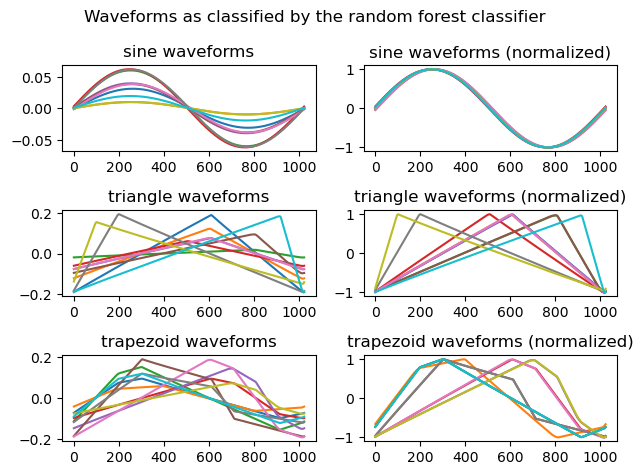

In [ ]:
# predict the waveform type for each waveform
y_pred = clf.predict(waveforms)

# plot the first few of each type of waveform
# 0 = sine, 1 = triangle, 2 = trapezoid
# plot the first 10 of each type of waveform

# randomly select 10 waveforms of each type
sine_idx = np.random.choice(np.where(y_pred == 0)[0], 10)
triangle_idx = np.random.choice(np.where(y_pred == 1)[0], 10)
trap_idx = np.random.choice(np.where(y_pred == 2)[0], 10)

# plot the waveforms
plt.figure()


plt.subplot(3, 2, 1)
plt.title("sine waveforms")
plt.plot(raw_waveforms[sine_idx][:10].T, label="sine")
plt.xlabel("Time")
plt.ylabel("Amplitude")


plt.subplot(3, 2, 3)
plt.title("triangle waveforms")
plt.plot(raw_waveforms[triangle_idx][:10].T, label="triangle")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.subplot(3, 2, 5)
plt.title("trapezoid waveforms")
plt.plot(raw_waveforms[trap_idx][:10].T, label="trapezoid")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.subplot(3, 2, 2)
plt.title("sine waveforms (normalized)")
plt.plot(waveforms[sine_idx][:10].T, label="sine")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.subplot(3, 2, 4)
plt.title("triangle waveforms (normalized)")
plt.plot(waveforms[triangle_idx][:10].T, label="triangle")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.subplot(3, 2, 6)
plt.title("trapezoid waveforms (normalized)")
plt.plot(waveforms[trap_idx][:10].T, label="trapezoid")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.suptitle("Waveforms as classified by the random forest classifier trained on N87 data")
plt.tight_layout()
plt.show()


In [ ]:
# dump the model so we can use it later
# import pickle
# with open("week_4_waveform_classifier.pkl", "wb") as f:
#     pickle.dump(clf, f)


# it can be reloaded and used with the following commands
import pickle
with open("week_4_waveform_classifier.pkl", "rb") as f:
    clf = pickle.load(f)
y_pred = clf.predict(waveforms)

